# Personalized recommendation only for repeat buyers: training objective is always user → item preference, not item ↔ item co-occurrence.



item_similarity matrix is built from the user–item interaction matrix.
Each column is an item vector showing which users bought it (and how strongly, e.g. with log1p weights).
To compute similarity between two items, you compare those columns.
👉 So two items will have high cosine similarity if:
Many of the same users bought both, and
Their purchase patterns (weights) are similar.

## 1) Goal

Recommend items to users, using only **purchase (0/1) histories**.


### 🔹 User similarity (user–user CF)

* Two users are considered **similar** if they **interacted with the same items in similar ways**.
* You compare **rows** of the user–item matrix.
* Example: if Alice and Bob both bought mostly the same products, their vectors look alike → high similarity.

---

### 🔹 Item similarity (item–item CF)

* Two items are considered **similar** if they are **consumed by the same users**.
* You compare **columns** of the user–item matrix.
* Example: if product A and product B are often bought by the same customers, their vectors look alike → high similarity.
---

### 🔹 Concept in words

* **User similarity**: “Find other people who behave like me, then recommend what they bought.”
* **Item similarity**: “Find products that behave alike across customers, then recommend them to me based on what I bought.”


Good question 👍 You already tried **item–item KNN with cosine similarity** on the user–item matrix. That’s the most basic collaborative filtering way to find similar items. But there are several **more robust methods** you can try to get better and less noisy “similar items” signals.

---


## 2. Matrix Factorization (Latent Factors)

* Learn hidden factors (FunkSVD, ALS, etc.).
* Then compute **item similarity in latent space**: items that project to similar factor vectors are “similar.”
* This is usually more robust because it captures *deeper patterns* (e.g., both items load on “organic food” factor), not just co-purchases.

---

## 3. Item Embeddings

* Treat each basket (or order) like a “sentence” and each item like a “word.”
* Train embeddings with **Word2Vec/Skip-gram/CBOW** or newer methods.
* Similar items end up close in embedding space, which is often smoother and less sparse than co-purchase counts.

---

## 4. Bayesian/Probabilistic Models

* Models like **Bayesian Personalized Ranking (BPR)** or **Poisson Factorization** generate item similarity from a probabilistic perspective.
* These models are especially good for implicit feedback (purchases, clicks).

---

## 5. Hybrid Approaches

* Combine **collaborative signals** with **content similarity** (semantic embeddings, metadata).
* Example: If two items rarely co-occur but are textually or visually similar, hybrid scoring can still surface them.








# Hybrid methods help: combine factorization with neighborhood or graph-based closeness. standard user–item factorization ignores side information (demographics, cast, reviews, genres)., adding content/meta-data into MF makes recommenders more accurate and sometimes more interpretable, but harder to compute. Collective factorization: jointly factorize multiple matrices (user–item, movie–cast, movie–reviews, etc.) so entities share latent vectors.


If your goal is ranking items for recommendation (top-N lists) → Bayesian Personalized Ranking BPR-MF is the better choice than logistic. Better suited for recommendation lists where the order matters. BPR trains recommenders to rank bought items higher than not-bought items, using implicit feedback Learn the blend: train models (logistic, trees, or learning-to-rank) to set weights/features from data. MF + BPR loss → learns latent factors optimized for ranking (top-N recommendation). 

* **Blending:** final score $= \alpha \cdot \text{MF} + \beta \cdot \text{popularity} + \gamma \cdot \text{copurchase}$. Tune $\alpha,\beta,\gamma$ offline by NDCG\@K; verify with A/B.



* **General recipe:** A recommender = **model** (e.g., MF, linear regression, nearest-neighbor) + **parameters** (θ) + **loss/utility function** + **optimization algorithm**.
* **Training loop:**

  1. Use parameters → make predictions.
  2. Measure error/utility.
  3. Update parameters (e.g., gradient descent).
  4. Repeat until convergence.
* **Models:** can be global mean, bias models, linear regression, matrix factorization, etc.
* **Metrics to optimize:**

  * RMSE (prediction accuracy).
  * Classification accuracy (good vs. bad).
  * Ranking accuracy (top-N).
* **Optimization:** typically gradient descent (needs differentiable loss), sometimes EM or other iterative methods.

Ensembles win: Blend diverse models (MF, neighborhood, RBM, etc.) — a few strong ones often suffice. Many small, complementary predictors beat one “perfect” model.

* **Matrix setup:** Instead of ratings (1–5), use a **binary matrix**:

  * 1 if a user purchased an item.
  * 0 if not (missing/unknown).

* **Bias:** Biases first: Model global/user/item effects (means) — they matter a lot. Instead of rating means, the baseline becomes **popularity** (global, per-item, per-user purchase rates).

* **Normalization:** Center by subtracting these purchase probabilities (so frequent buyers or p\opular items don’t dominate).

* **Factorization:** Apply SVD/matrix factorization to this binary (or normalized) matrix → find latent factors of *why* items are co-purchased. Sparse-aware MF: Use matrix factorization that fits only observed entries (not dense SVD).

* **Scoring:** Predicted score = baseline purchase probability + user–item dot product in latent space.

  * High score = higher predicted likelihood of purchase.

* **Evaluation:**

  * Ratings → RMSE.
  * Purchases → ranking metrics (precision\@k, recall\@k, nDCG), since we only care about “what will the user buy next.”

👉 **Lesson:** It’s the same pipeline, but you swap “rating values” with “purchase indicators,” and evaluate with **ranking-based metrics** instead of rating accuracy.

Do you want me to give you a **1–2 sentence “purchase version” rewrite** of your original short learning list?

RMSE ≠ product impact: Ranking/top-N and online A/B tests are more aligned with business goals.


* Start with a big **user–item interaction matrix** (ratings, purchases, clicks).
* Initialize random **user vectors** ($p_u$) and **item vectors** ($q_i$).
* Define a **loss function** (e.g., squared error between actual vs predicted rating, or BPR for ranking).
* Use **optimization (like gradient descent)** to adjust the vectors so that:

  * items a user liked/bought get **higher predicted scores**,
  * items they ignored get **lower scores**.

👉 Over many updates, the vectors capture hidden patterns (“user likes sci-fi,” “item is a comedy”) so that the **dot product = predicted preference**.

In [126]:
import pandas as pd

cols = ['shopUserId', 'orderId', 'quantity', 'groupId', 'created']
tx = pd.read_csv('../data/processed//transactions_clean.csv', usecols=cols + ['status'], low_memory=False)
tx = tx[tx['status'] == 'active'][cols].astype({'quantity': int})
tx

,shopUserId,orderId,quantity,groupId,created
0,812427,785001,1,261873,2025-08-05 20:14:28
1,831360,784985,4,261745,2025-08-05 19:55:36
2,209204,784978,1,265298,2025-08-05 19:47:22
4,831340,784977,1,260596,2025-08-05 19:46:09
5,831340,784977,1,260596,2025-08-05 19:46:09
...,...,...,...,...,...
250024,78202,158870,1,221416,2024-05-22 14:18:16
250026,78181,158841,1,265843,2024-05-22 13:42:39
250038,78145,158800,1,261518,2024-05-22 12:54:51
250039,78136,158791,1,542087,2024-05-22 12:44:01


In [127]:
# keep only users with ≥3 distinct orders (by orderId)
orders = tx[["shopUserId", "orderId"]].drop_duplicates()
keep = orders.groupby("shopUserId").size().ge(3)
tx = tx[tx["shopUserId"].isin(keep[keep].index)].copy()
tx

,shopUserId,orderId,quantity,groupId,created
2,209204,784978,1,265298,2025-08-05 19:47:22
17,598630,784929,1,250194,2025-08-05 19:03:48
22,250624,784921,1,240281,2025-08-05 18:52:02
23,250624,784921,1,270606,2025-08-05 18:52:02
24,233349,784904,1,240201,2025-08-05 18:31:48
...,...,...,...,...,...
249944,78731,159449,1,266494,2024-05-23 15:41:24
249945,78698,159412,1,261712,2024-05-23 15:02:12
250021,78212,158877,1,261324,2024-05-22 14:30:05
250022,78212,158877,1,261324,2024-05-22 14:30:05


In [128]:
# sort by user + time
tx = tx.sort_values(["shopUserId", "created"])

# last order of each user → test
test_idx = tx.groupby("shopUserId")["created"].idxmax()
test  = tx.loc[test_idx]
train = tx.drop(test_idx)

# keep only test items that also exist in train
test = test[test["groupId"].isin(train["groupId"])]

# keep train only for users that remain in test
valid_users = test["shopUserId"].unique()
train = train[train["shopUserId"].isin(valid_users)]

test.shape, train.shape

((2523, 5), (15933, 5))

In [129]:
import numpy as np

# --- compute IDF on train only ---
user_per_item = train.groupby("groupId")["shopUserId"].nunique()
N_users = train["shopUserId"].nunique()
idf = np.log1p(N_users / (1.0 + user_per_item))

# --- apply TF * IDF ---
def add_weights(df):
    df = df.copy()
    df = df.merge(idf.rename("idf"), on="groupId", how="left")
    df["idf"] = df["idf"].fillna(np.log1p(N_users))  # fallback for unseen items
    df["interaction"] = np.log1p(df["quantity"]) * df["idf"]
    return df

train = add_weights(train)
test  = add_weights(test)

In [130]:
train

,shopUserId,orderId,quantity,groupId,created,idf,interaction
0,78181,158841,1,265843,2024-05-22 13:42:39,3.141199,2.177313
1,78181,631793,1,265823,2025-03-20 13:32:48,5.006706,3.470384
2,78181,631793,1,270794,2025-03-20 13:32:48,5.890064,4.082682
3,78181,631793,1,263855,2025-03-20 13:32:48,3.247863,2.251247
4,78181,740536,1,240201,2025-06-19 11:09:48,4.750843,3.293034
...,...,...,...,...,...,...,...
15928,821802,783948,1,261772,2025-08-05 07:57:24,5.199680,3.604144
15929,821802,783948,1,261822,2025-08-05 07:57:24,5.534575,3.836275
15930,821802,783948,1,260922,2025-08-05 07:57:24,3.699371,2.564209
15931,821802,784021,1,261822,2025-08-05 08:40:31,5.534575,3.836275


In [131]:
# aggregate with sum
train = train.groupby(["shopUserId","groupId"], as_index=False)["interaction"].sum()
test  = test.groupby(["shopUserId","groupId"], as_index=False)["interaction"].sum()

# cap interactions at max 20
#train["interaction"] = train["interaction"].clip(upper=20)
#test["interaction"] = test["interaction"].clip(upper=20)

In [132]:
train

,shopUserId,groupId,interaction
0,78181,240201,3.293034
1,78181,263855,2.251247
2,78181,265823,3.470384
3,78181,265843,2.177313
4,78181,270794,4.082682
...,...,...,...
11412,810333,241687,3.643316
11413,810333,261888,21.936616
11414,821802,260922,7.692626
11415,821802,261772,7.208287


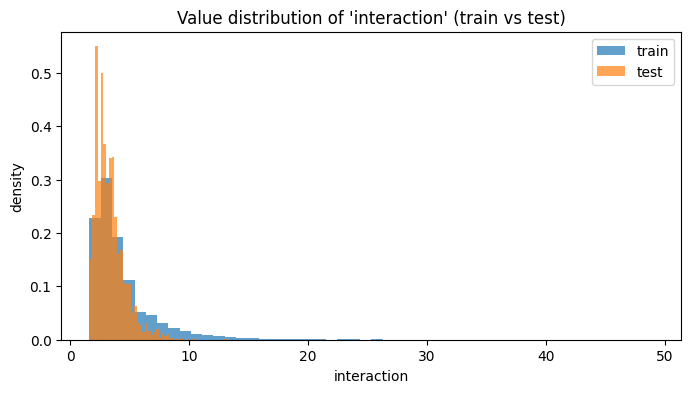

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(train["interaction"], bins=50, alpha=0.7, label="train", density=True)
plt.hist(test["interaction"], bins=50, alpha=0.7, label="test", density=True)
plt.xlabel("interaction")
plt.ylabel("density")
plt.title("Value distribution of 'interaction' (train vs test)")
plt.legend()
plt.show()


In [134]:
train[train["interaction"] > 10].sort_values("interaction", ascending=False)


,shopUserId,groupId,interaction
173,80134,261144,49.035735
2064,188529,266072,42.323245
11385,791987,544806,42.095834
10146,528903,218982,40.289682
2693,213458,261253,39.827061
...,...,...,...
3185,231760,262008,10.075658
8238,373494,264549,10.075658
3579,242504,261610,10.057587
8376,379205,292789,10.053625


In [28]:
# Assumes: import pandas as pd, import numpy as np

df = user_item.copy()
df["created"] = pd.to_datetime(df["created"])

# --- Identify last order per user (only users with ≥2 orders) ---
orders = df.groupby(["shopUserId", "orderId"], as_index=False)["created"].max()
multi_users = orders["shopUserId"].value_counts()[lambda x: x >= 2].index
last_orders = (
    orders[orders["shopUserId"].isin(multi_users)]
    .sort_values("created")
    .groupby("shopUserId")
    .tail(1)
)

# Mark rows that belong to the last order for those users
tmp = df.merge(
    last_orders[["shopUserId", "orderId"]],
    on=["shopUserId", "orderId"],
    how="left",
    indicator=True
)
is_last_order_row = tmp["_merge"].eq("both")

# Candidate training pool = all rows NOT in the user's last order
train_candidates = tmp.loc[~is_last_order_row].drop(columns="_merge").copy()

# For each user's last order, select ONE item to hold out for test.
# Prefer an item whose groupId already appears in train_candidates to ensure item coverage.
test_rows = []
for uid, group in tmp.loc[is_last_order_row].groupby("shopUserId"):
    # Items in this user's last order
    order_items = group.copy()

    # Prefer an item seen in training (by any user) to avoid cold items in test
    seen_items = set(train_candidates["groupId"].unique())
    maskable = order_items[order_items["groupId"].isin(seen_items)]

    if not maskable.empty:
        # Deterministic choice: pick the latest created within the last order among seen items
        mask_row = maskable.sort_values("created").tail(1)
    else:
        # Fallback: if all items are cold, just take the latest item in the order
        mask_row = order_items.sort_values("created").tail(1)

    test_rows.append(mask_row)

# Build TEST = one row per user
test_df = pd.concat(test_rows, ignore_index=False).copy()

# TRAIN = everything except the masked test rows
train_df = tmp.drop(index=test_df.index).drop(columns="_merge")

# De-dup (just in case) 
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

# --- Checks ---
print(f"Missing items in TRAIN: {np.setdiff1d(test_df['groupId'], train_df['groupId']).size}")
print(f"Missing users in TRAIN: {np.setdiff1d(test_df['shopUserId'], train_df['shopUserId']).size}")
print(f"TRAIN: {train_df.shape}, TEST: {test_df.shape}")
print(f"Unique items TRAIN: {train_df['groupId'].nunique()}, TEST: {test_df['groupId'].nunique()}")
print(f"Unique users TRAIN: {train_df['shopUserId'].nunique()}, TEST: {test_df['shopUserId'].nunique()}")


Missing items in TRAIN: 0
Missing users in TRAIN: 0
TRAIN: (102342, 5), TEST: (6390, 6)
Unique items TRAIN: 255, TEST: 249
Unique users TRAIN: 52309, TEST: 6390


# 
 **Why use LabelEncoder for user and item IDs?**
# 
Libraries like `scipy.sparse.coo_matrix` and `NearestNeighbors` require user and item indices to be consecutive integers starting from 0. However, our original IDs (`shopUserId` and `groupId`) are large, non-consecutive numbers. 
# 
 `LabelEncoder` transforms these IDs into dense integer indices (`user_idx` and `item_idx`), mapping each unique user and item to a unique integer in `[0, n-1]`. This makes it possible to efficiently construct and work with sparse user–item matrices for collaborative filtering.


In [29]:
from sklearn.preprocessing import LabelEncoder

# Fit encoders on TRAIN only
user_enc = LabelEncoder().fit(train_df["shopUserId"])
item_enc = LabelEncoder().fit(train_df["groupId"])

# User index → original user ID
idx_to_user = dict(zip(range(len(user_enc.classes_)), user_enc.classes_))

# Item index → original product ID
idx_to_item = dict(zip(range(len(item_enc.classes_)), item_enc.classes_))

# (optional) inverse: original ID → index
user_to_idx = {u: i for i, u in idx_to_user.items()}
item_to_idx = {i: j for j, i in idx_to_item.items()}


# Encode train
train_df["user_idx"] = user_enc.transform(train_df["shopUserId"])
train_df["item_idx"] = item_enc.transform(train_df["groupId"])

# Encode test, drop unseen users/items
mask = test_df["shopUserId"].isin(user_enc.classes_) & test_df["groupId"].isin(item_enc.classes_)
test_df = test_df.loc[mask].copy()

test_df["user_idx"] = user_enc.transform(test_df["shopUserId"])
test_df["item_idx"] = item_enc.transform(test_df["groupId"])

# Decode later
#recommended_items = [idx_to_item[i] for i in top_item_indices]

In [30]:
train_df.sort_values(by="interaction", ascending=False)

,shopUserId,orderId,groupId,created,interaction,user_idx,item_idx
4783,144280,180873,261637,2024-06-14 12:08:07,3.044522,1714,94
90334,707428,654239,261916,2025-04-07 08:11:38,3.044522,41994,116
102690,777342,728010,261637,2025-06-06 17:30:52,2.944439,48847,94
1834,92196,183318,291930,2024-06-16 16:54:11,2.944439,626,220
47028,411749,335374,261920,2024-10-04 08:06:46,2.833213,20275,117
...,...,...,...,...,...,...,...
42506,391253,312631,290153,2024-09-20 11:05:31,0.693147,18193,181
42504,391253,312631,263855,2024-09-20 11:05:31,0.693147,18193,133
42503,391252,312632,292078,2024-09-20 11:06:09,0.693147,18192,223
42502,391252,312632,242305,2024-09-20 11:06:09,0.693147,18192,30


In [31]:
from scipy.sparse import csr_matrix
import numpy as np

X_train = csr_matrix(
    (train_df["interaction"].values,
     (train_df["user_idx"].values, train_df["item_idx"].values)),
    shape=(len(user_enc.classes_), len(item_enc.classes_)),
    dtype=np.float32
)

In [60]:
# compute low-rank factors with sparse SVD
from scipy.sparse.linalg import svds

K = 150  # latent dimensions (start small; tune later)

U, S, Vt = svds(X_train, k=K)
# svds returns ascending singular values — reorder to descending
order = np.argsort(S)[::-1]
S = S[order]; U = U[:, order]; Vt = Vt[order, :]

# User/item latent factors (scaled by singular values)
user_factors = U * S        # shape: (n_users, K)
item_factors = Vt.T         # shape: (n_items, K)


In [61]:
# Popularity + latent similarity (no overlap filter)

# 1) Precompute popularity (unique buyers per item) and a soft penalty
Xb   = X_train.copy(); Xb.data[:] = 1.0
item_pop = np.asarray(Xb.sum(axis=0)).ravel()            # #buyers per item
pop_penalty = 1.0 / np.log1p(np.maximum(item_pop, 1))    # softer than 1/sqrt(pop)

# Normalize item factors first (needed for cosine similarities in latent space)
from numpy.linalg import norm

item_vecs = item_factors / np.maximum(norm(item_factors, axis=1, keepdims=True), 1e-12)

# Similar items in latent space with popularity damp (no overlap filter)
def similar_items(item_idx, top_n=10):
    sims_all = item_vecs @ item_vecs[item_idx]                 # latent cosine
    sims_all[item_idx] = -np.inf                               # exclude self

    sims = sims_all * pop_penalty
    k = min(top_n, np.sum(np.isfinite(sims)))
    if k == 0:
        return np.array([], dtype=int), np.array([])

    top = np.argpartition(sims, -k)[-k:]
    order = top[np.argsort(sims[top])[::-1]]
    return order, sims[order]


In [62]:
import numpy as np

# Binary version of X_train (user × item)
Xb = X_train.copy()
Xb.data[:] = 1.0

# Pick a random item index
rand_item_idx = np.random.randint(len(item_enc.classes_))

# Get latent-space recs
rec_idxs, rec_scores = similar_items(rand_item_idx, top_n=10)

# Decode to original item IDs
rand_item_id = idx_to_item[rand_item_idx]
rec_item_ids = [idx_to_item[i] for i in rec_idxs]

print(f"Random item: {rand_item_id}")
print("Recommended similar items:")

# Seed vector (all users who bought the random item)
seed_vec = Xb[:, rand_item_idx]

for iid, score, ridx in zip(rec_item_ids, rec_scores, rec_idxs):
    # Candidate vector (all users who bought candidate item)
    cand_vec = Xb[:, ridx]
    # Co-occurrence = overlap in users/baskets
    cooc = int((seed_vec.multiply(cand_vec)).sum())

    print(f"  {iid} (score={score:.4f}, co-occur={cooc})")


Random item: 261699
Recommended similar items:
  270302 (score=0.2933, co-occur=1)
  270301 (score=0.0912, co-occur=1)
  261708 (score=0.0198, co-occur=3)
  261703 (score=0.0181, co-occur=8)
  210764 (score=0.0163, co-occur=2)
  290261 (score=0.0153, co-occur=3)
  291839 (score=0.0136, co-occur=5)
  270586 (score=0.0129, co-occur=9)
  260018 (score=0.0109, co-occur=4)
  290207 (score=0.0095, co-occur=1)


In [58]:
import numpy as np

def hitrate_at_k(user_factors, item_factors, test_df, idx_to_item, k=10):
    scores = user_factors @ item_factors.T
    hits = 0

    for _, row in test_df.iterrows():
        u_idx = row["user_idx"]
        true_item_idx = row["item_idx"]

        # Predicted scores for this user
        user_scores = scores[u_idx]

        # Top-K recommended items (excluding already interacted items, optional)
        topk = np.argpartition(-user_scores, k)[:k]

        if true_item_idx in topk:
            hits += 1

    return hits / len(test_df)

# Example usage
hr10 = hitrate_at_k(user_factors, item_factors, test_df, idx_to_item, k=10)
print(f"Hit Rate@10: {hr10:.4f}")


Hit Rate@10: 0.3316


In [59]:
no_recs = 0
total_items = item_vecs.shape[0]

for i in range(total_items):
    nbrs, scores = similar_items(item_idx=i)
    if len(nbrs) == 0:
        no_recs += 1

print(f"Items with no recs: {no_recs} / {total_items} "
      f"({no_recs / total_items:.1%})")


Items with no recs: 0 / 255 (0.0%)


In [10]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(X_train.T)

distances, indices = knn.kneighbors(X_train.T, n_neighbors=75)

In [11]:
# Drop the self-neighbor (first column)
distances, indices = distances[:, 1:], indices[:, 1:]

In [12]:
# Convert distances to similarities
similarities = 1.0 - distances

In [13]:
# Keep the neighbor indices and their similarities
neighbors_idx = indices
neighbors_sim = similarities

## given the list of items in a user’s basket, sums up the neighbor similarities to generate candidate scores.

In the adjustment I suggested, each candidate item’s similarity contributions are **scaled down by a popularity penalty**:


  * $1 / \log(1 + \text{pop}(j))$ → softer penalty

In [14]:
# Precompute once
Xb = X_train.copy(); Xb.data[:] = 1.0
Xcsc = X_train.copy(); Xcsc.data[:] = 1.0; Xcsc = Xcsc.tocsc()
item_pop = np.asarray(Xb.sum(axis=0)).ravel()                 # #buyers per item
pop_penalty = 1.0 / np.log1p(np.maximum(item_pop, 1))         # 1 / log(1 + pop)



In [15]:
# Preconditions (done once):

MIN_OVERLAP = 10   # require many shared buyers
ALPHA = 150        # shrink tiny overlaps (tune 50–200)

def recommend_for_basket(basket_items, top_n=10):
    scores = np.zeros(X_train.shape[1], dtype=np.float32)
    seen = set(basket_items)
    for i in basket_items:
        js   = neighbors_idx[i]
        sims = neighbors_sim[i]
        ov   = (Xcsc[:, i].T @ Xcsc[:, js]).A.ravel()   # shared buyers
        keep = ov >= MIN_OVERLAP
        if keep.any():
            # overlap-weighted similarity * soft popularity penalty
            w = (ov[keep] / (ov[keep] + ALPHA)) * pop_penalty[js[keep]]
            scores[js[keep]] += sims[keep] * w
    # don’t recommend items already in basket
    for i in seen:
        scores[i] = -np.inf
    top = np.argpartition(scores, -top_n)[-top_n:]
    return top[np.argsort(scores[top])[::-1]]


In [16]:
import numpy as np

K = 10
hits = 0
total = 0

for oid, g in test_df.groupby("orderId"):
    items = g["item_idx"].unique().tolist()
    if len(items) < 2:  # need context + target
        continue
    target = items[0]                 # or: np.random.choice(items)
    context = [i for i in items if i != target]
    rec = recommend_for_basket(context, top_n=K)
    hits += int(target in rec)
    total += 1

hitrate = hits / max(total, 1)
print(f"HitRate@{K}: {hitrate:.3f}  (orders evaluated: {total})")


HitRate@10: 0.274  (orders evaluated: 2513)


In [17]:
# filtered neighbor counts using your MIN_OVERLAP
Xb = X_train.copy(); Xb.data[:] = 1.0
Xcsc = Xb.tocsc()

MIN_OVERLAP = 10  # same as in your scorer
filtered_counts = np.zeros(X_train.shape[1], dtype=int)

for i in range(X_train.shape[1]):
    js = neighbors_idx[i]
    if js is None or len(js) == 0:
        filtered_counts[i] = 0
        continue
    ov = (Xcsc[:, i].T @ Xcsc[:, js]).A.ravel()
    filtered_counts[i] = int((ov >= MIN_OVERLAP).sum())

print(f"Items with 0 neighbors (filtered): {(filtered_counts==0).sum()} / {len(filtered_counts)} "
      f"({(filtered_counts==0).mean():.1%})")
print("Median neighbors/item (filtered):", np.median(filtered_counts))
print("10th pct:", np.percentile(filtered_counts, 10))
print("90th pct:", np.percentile(filtered_counts, 90))


Items with 0 neighbors (filtered): 856 / 1097 (78.0%)
Median neighbors/item (filtered): 0.0
10th pct: 0.0
90th pct: 9.0


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

def pick_seed_with_legit_neighbors(Xcsc, neighbors_idx, MIN_OVERLAP, max_tries=500):
    n_items = len(neighbors_idx)
    for _ in range(max_tries):
        i = int(rng.integers(0, n_items))
        js = neighbors_idx[i]
        if js is None or len(js) == 0: 
            continue
        ov = (Xcsc[:, i].T @ Xcsc[:, js]).A.ravel()
        if (ov >= MIN_OVERLAP).any():
            return i
    # fallback: first item that has any neighbors
    for i in range(n_items):
        js = neighbors_idx[i]
        if js is not None and len(js) > 0:
            return i
    return 0

def visualize_recs_for_single_item(seed_item=None, top_n=10):
    # pick a seed with legit neighbors if none provided
    if seed_item is None:
        seed_item = pick_seed_with_legit_neighbors(Xcsc, neighbors_idx, MIN_OVERLAP)

    # get recs for a one-item basket
    rec_idx = recommend_for_basket([seed_item], top_n=top_n)

    # compute per-edge contributions for the seed
    js   = neighbors_idx[seed_item]
    sims = neighbors_sim[seed_item]
    ov   = (Xcsc[:, seed_item].T @ Xcsc[:, js]).A.ravel()
    # weights used in your scorer
    w = (ov / (ov + ALPHA + 1e-8)) * pop_penalty[js]
    contrib = sims * w

    # explanation rows only for recommended items
    rows = []
    for j in rec_idx:
        where = np.where(js == j)[0]
        if where.size == 0:
            continue
        k = where[0]
        rows.append({
            "seed_item_idx": seed_item,
            "seed_groupId": idx_to_item.get(seed_item, seed_item),
            "rec_item_idx": int(j),
            "rec_groupId": idx_to_item.get(int(j), int(j)),
            "cosine_sim": float(sims[k]),
            "overlap_users": int(ov[k]),
            "weight_overlap_shrink": float(ov[k] / (ov[k] + ALPHA + 1e-8)),
            "weight_pop_penalty": float(pop_penalty[js[k]]),
            "final_score_contribution": float(contrib[k]),
        })

    df = pd.DataFrame(rows).sort_values("final_score_contribution", ascending=False).reset_index(drop=True)
    print(f"Seed item: idx={seed_item}, groupId={idx_to_item.get(seed_item, seed_item)}")
    display(df)  # Jupyter display; or print(df.head(10))

    # quick bar chart of scores
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(df)), df["final_score_contribution"])
    plt.xticks(range(len(df)), [str(x) for x in df["rec_groupId"]], rotation=45, ha="right")
    plt.ylabel("Score")
    plt.title(f"Recommendations for seed {idx_to_item.get(seed_item, seed_item)}")
    plt.tight_layout()
    plt.show()

# usage:
# visualize_recs_for_single_item(seed_item=None, top_n=10)


Seed item: idx=768, groupId=292375


,seed_item_idx,seed_groupId,rec_item_idx,rec_groupId,cosine_sim,overlap_users,weight_overlap_shrink,weight_pop_penalty,final_score_contribution
0,768,292375,767,292367,0.119872,11,0.068323,0.214871,0.001760
1,768,292375,766,292359,0.071455,12,0.074074,0.208516,0.001104


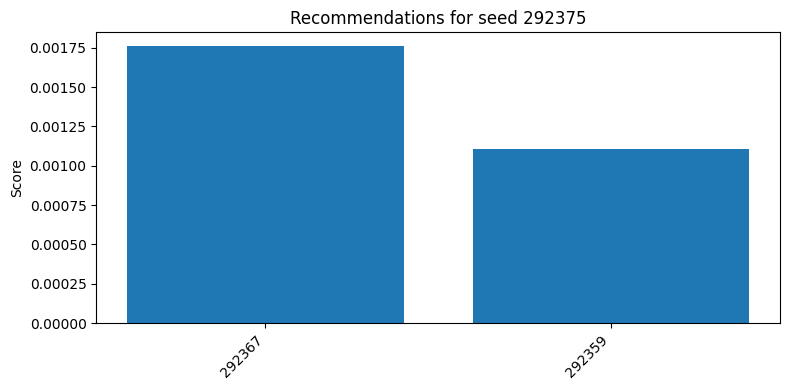

In [23]:
visualize_recs_for_single_item(seed_item=None, top_n=10)


?? Is the approach of Top-n precision evaluation. In this plan we’ll use all customers who have at least 10 product purchases, and measure the top-3 precision of recommendations using a 5-fold cross-validation against a random 80% training/20% test set. We measure as a “hit” anything withheld from the test set. We will identify the best few algorithm candidates based on highest top-3 precision. 